# Macro III - Solving the Original Huggett Model (Huggett, 1993, JEDC)

Vinícius de Almeida Nery Ferreira

In [1]:
# Importing packages
## Data
import numpy as np

## Plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

## Other
import random
import time
from tqdm import tqdm

# Setting seeds for random
random.seed(121019)
np.random.seed(121019)

In the model of Huggett, the starting point is a standard bond economy, where households choose consumption and how much to invest in bonds.

However, we **don't have complete markets**: agents are hit by idiosyncratic shocks that are only *partially insurable*.

That is, the bonds they trade are not state-contingent, and so we have incomplete markets (we don't have a bond for each possible period-state pair: there are many more goods than states).

This leads to ex-ante identical agents being **heterogenous ex-post**.

The household's problem is 

$$
\max_{\{c_t, a_{t+1}\}_{t=0}^{\infty}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_t),
$$

subject to

$$
\begin{cases}
c_t + q \cdot a_{t+1} = z_t + a_t, \quad c \geq 0 \\
z \sim \text{a Markov Process.}
\end{cases}
$$

where $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$ and $\mathbb{E}_0$ denotes the expected value conditional on the information set at period 0.

$a_t$ denotes bonds/financial assets. 
$z_t$ can be viewed as a labor income shock.
$q_t = \frac{1}{1 + r_t}$ is the bond price, where $r$ is interest rate.

The Bellman Equation of this problem can be written as

$$
V(a, z) = \max_{a'}\left\{u \left( a + z - qa' \right) + \beta \mathbb{E}\left[ V(a', z') | z = \hat{z} \right] \right\}
$$,

where we must conditional on $z = \hat{z}$ since $z$ follows a Markov process.

Furthermore, we stablish an *ad-hoc* borrowing limit, $a' > \underline{a} > -\infty$.
Note that, otherwise, agent would want $a' = -\infty$.

Finally, note that the Euler Equation of the problem is

$$
u'(c_t) = \beta (1+r_t) \mathbb{E}_t[u'(c_{t+1})]
$$

since marginal gains of consumption today have to equal its marginal costs (in expected value) tomorrow.

Since $u$ satisfies the INADA conditions, note that $\beta (1+r_t) > 1$ implies

$$
u'(c_t) = \beta (1+r_t) \mathbb{E}_t[u'(c_{t+1})] > \mathbb{E}_t[u'(c_{t+1})]
\quad \therefore \quad
\mathbb{E}_t[c_t] < \mathbb{E}_t[u'(c_{t+1})]
$$

This means we would have explosive consumption, which would require explosive savings, which is not possible since number of states is fixed and we are in an infinite horizon that problem.

Huggett shows that, under the borrowing constraint and the assumption that $\beta (1+r_t) \leq 1$, the value function becomes a contraction in the relevant parameter space, and so we can solve it using the Contraction Mapping Theorem.

$$
V(a, z) = \max_{\underline{a} < a'< \overline{a}}\left\{u \left( a + z - qa' \right) + \beta \mathbb{E}\left[ V(a', z') | z = \hat{z} \right] \right\}
$$

## Parameters

In [2]:
# Parameters (period length is two months)
sigma = 1.5
T = 10000

In [3]:
# Income grid
## Shock states: employed or unemployed
num_states_shock = 2
num_shock_spaces = 2

## Income of each state (employed - unemployed)
income_grid = np.array([1, 0.1])

In [4]:
# Transition matrix
transition_matrix = np.array([[0.925, 0.075], [0.5, 0.5]])

# Printing transition matrix
print(np.around(transition_matrix, 3))

[[0.925 0.075]
 [0.5   0.5  ]]


## Asset Grid and Interest Rate

In [5]:
# Parameters to replicate Tiago's matlab code

beta = 0.9932

asset_lb = -2
asset_up = 2
num_states_assets = 351
asset_grid = np.linspace(asset_lb, asset_up, num_states_assets)

print(f"Distance between points: {round(asset_grid[1] - asset_grid[0], 2)}")

Distance between points: 0.01


## Consumption and Utility Functions

We need to create a consumption and utility matrix conditional on each possible shock (we have 2 in our case: employed or unemployed).
Thus, our shock space is the income grid.

This is because the current shock happens at beginning of the period, and so its current value is known to agents.

On tests, I found that results are a little bit sensitive to the form of the budget constraint (using interest rates or bond prices).
This makes results of item ***(d)*** onwards change by 0.1 to 0.2% in the case of the annual interest rates.

Following Tiago's code and Huggett's original formulation, we opt to go with the formulation with bond prices.

In [6]:
def consumption_asset(a, a_prime, param_dict):
    """ 
    Calculates consumption as a function of assets today, tomorrow and parameters
    """

    # Getting parameters
    income = param_dict['z']
    q = param_dict['q']
    r = param_dict['r']

    # Calculating consumption
    consumption = a + income - q * a_prime  # using bond price
    # consumption = (1 + r) * a + income - a_prime  # using interest rate

    # Consumption has to be positive
    consumption = np.maximum(consumption, 1e-6)

    # Returning
    return consumption

In [7]:
def utility_asset(a, a_prime, param_dict):
    """ 
    Calculates utility as a function of assets today, tomorrow and parameters
    """

    # Getting parameters
    sigma = param_dict['sigma']

    # Calculating consumption
    consumption = consumption_asset(a, a_prime, param_dict)

    # Utility
    return (1 / (1 - sigma)) * consumption ** (1 - sigma)

In [8]:
def get_utility_conditional_on_shock(a, a_prime, param_dict_uncertainty, shock_space):
    """
    Calculates utility matrices as a function of assets today, tomorrow
    and parameters, conditional on each value of employment.
    Returns an array of matrices of utility for each possible combination of a, a_prime and shock
    """
    
    # Number of shocks and capital states
    n_shock_space = shock_space.shape[0]
    n_asset_space = a.shape[0]

    # Array
    conditional_utility_array = np.zeros([n_shock_space, n_asset_space, n_asset_space])

    # Loop to fill arrays
    for index, income in enumerate(shock_space):
        # Filling
        param_dict_uncertainty['z'] = income

        # Calculating consumption and utility
        ## Recall we want a today in the columns and a' tomorrow in the rows, so we transpose at the end
        conditional_utility_array[index] = utility_asset(a, a_prime, param_dict_uncertainty).T

    # Changing back
    param_dict_uncertainty['z'] = 1

    # Returning
    return conditional_utility_array

## Value Function

In [9]:
def value_function_iteration_uncertainty(a_space, shock_space, shock_transition_matrix,
                                         param_dict, tol=1e-6, max_iter=5000):
    """
    Iterating through vectors (function approximations) until we reach a fixed point conditional on all shocks.
    Ideally, we would pass the utility_capital function an its parameters as arguments to make this more general.
    """

    # Parameters
    beta = param_dict['beta']

    # Assuring spaces are arrays
    a_space = np.array(a_space)
    shock_space = np.array(shock_space)

    # Getting dimensions of matrices and vectors
    num_asset_spaces = a_space.shape[0]
    num_shock_spaces = shock_space.shape[0]

    # Initial guess
    ## Matrix of conditional value functions
    ## V approximates the value function: for every shock and asset combination,
    ## it should give the maximum value attained
    V = np.zeros([num_shock_spaces, num_asset_spaces])
    V_new = np.ones([num_shock_spaces, num_asset_spaces])

    # Creating meshgrid, which give coordinates of a and a'
    a_matrix, a_prime_matrix = np.meshgrid(a_space, a_space)

    # Array with utilities for each possible combination of a, a' and shock value
    ## For each shock value (first dimension), returns a matrix of utility for space tomorrow
    ## in rows (second dimension) and state today in columns (third dimension)
    u_array_conditional_shock = get_utility_conditional_on_shock(
        a=a_matrix, a_prime=a_prime_matrix, 
        shock_space=shock_space, param_dict_uncertainty=param_dict
    )

    # Iterating
    for num_iter in range(max_iter):
        # Calculating matrix of possible values of V: for every state today (column),
        # what is the value of each state tomorrow (row) conditional on each shock

        ## Loop
        for index_shock in range(num_shock_spaces):
            # Expected value tomorrow
            expected_V_tomorrow = shock_transition_matrix[[index_shock]] @ V

            # Transforming into a vector
            expected_V_tomorrow = expected_V_tomorrow[0, :]

            ## Important: in numpy, operations between matrices (first term) and vectors (second term)
            ## are done column-wise. That is, we add B * V(a', z') to each column, which is exactly 
            ## what we want, as rows represent a' (see matrix on slide 27 of Lecture 4)
            matrix_state_values = u_array_conditional_shock[index_shock] + beta * expected_V_tomorrow

            # Calculating maximum value for each state today (columns, axis=1)
            # That is, for each column, we are grabbing the row (next state) which maximizes V for that state
            # (conditional on the productivity shock we are on)
            V_new[index_shock] = np.max(matrix_state_values, axis=1)

        # Checking if we found the fixed point using the sup norm FOR EACH shock
        # That is, we want the loop to stop when all conditions are satisfied
        if np.max(np.abs(V - V_new)) < tol:
            break
        else:
            V = V_new.copy() # this was a pain to discover that .copy() was necessary

    # Assessing convergence
    if num_iter >= max_iter - 1:
        print("Value function did not converge.")

    # Returning: V_new is now a matrix with the first dimension (rows) being the productivity shocks
    return V_new, num_iter

## Policy Function

We now have to find the policy function $a' = g(a, z)$ and $c = g_c(a, a') = g_c(a, g(a, z))$ through the restriction.

We have to do this for each realization of the shock (recall that the current shock happens at the beginning of the period, so it is known).

In [10]:
def policy_function(V, a_space, param_dict):
    """
    Returns a vector (approximation of a function) that, for every state today,
    gives the optimal state tomorrow.
    """
    # Relevant parameters
    beta = param_dict['beta']

    # Creating meshgrid, which give coordinates of a and a'
    a_matrix, a_prime_matrix = np.meshgrid(a_space, a_space)

    # Matrix with utilities for each possible combination of a and a'
    u_matrix = utility_asset(a=a_matrix, a_prime=a_prime_matrix, param_dict=param_dict).T

    # Calculating matrix of values of state tomorrow x state today
    matrix_state_values = u_matrix + beta * V
    
    # Idea: find indexes of values which give the optimal a' given a
    ## For each column (state today), we are finding the (index of) a' which maximizes the value
    ## The only difference from the value iteration is using np.argmax instead of np.max
    optimal_indexes = np.argmax(matrix_state_values, axis=1)

    # Finding the optimal values of a' for each a
    return a_space[optimal_indexes], optimal_indexes

In [11]:
def plot_policy_uncertainty(a_space, policy_a_matrix, 
                            policy_c_matrix, shock_space, 
                            title="Policy Functions"):
    # Object and title
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Define a colormap for the gradient
    cmap = plt.get_cmap('Accent')
    num_shocks = len(shock_space)
    
    # First graph: a' x a
    for i in range(num_shocks):
        color = cmap(i / num_shocks)
        ax[0].plot(a_space, policy_a_matrix[i, :], 
                   label=f"{shock_space[i]:.2f}", color=color)

    ax[0].plot(a_space, a_space, color='black', linewidth=.5, 
               linestyle='--', label=r"$a = a'$")
    ax[0].set_xlabel(r"State Today ($a$)", fontsize=10)
    ax[0].set_ylabel(r"State Tomorrow ($a'$)", fontsize=10)
    ax[0].set_title('Asset Policy Function', fontsize=12)
    ax[0].grid(True)
    
    # Second graph: c x k
    for i in range(num_shocks):
        color = cmap(i / num_shocks)
        ax[1].plot(a_space, policy_c_matrix[i, :], 
                   label=f"{shock_space[i]:.2f}", color=color)

    ax[1].set_xlabel(r"State Today ($a$)", fontsize=10)
    ax[1].set_ylabel(r"Consumption Today ($c$)", fontsize=10)
    ax[1].set_title('Consumption Policy Function', fontsize=12)
    ax[1].grid(True)

    # Create a common legend at the bottom
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, title=r'Current Income $z_t$',
               loc='lower center', 
               ncol=3, bbox_to_anchor=(0.5, -0.1))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

In [12]:
def simulate_markov_chain(state_grid, transition_matrix, T,
                          initial_value=None):
    """
    Simulates a Markov chain of length T given the characterization objects
    (state_grid, transition_matrix).
    If passed, initial_value must be an element of state_grid.
    """

    # Getting number of states
    N = state_grid.shape[0]

    # Computing cumulative distribution of the markov chain
    ## Skeleton
    cdf_markov_matrix = np.zeros([N, N])

    ## Looping
    for i in range(N):
        for j in range(N):
            # Summing row i of transition matrix until column j
            cdf_markov_matrix[i, j] = np.sum(transition_matrix[i, :j + 1])
    
    # Skeleton of markov process
    simulated_values = np.zeros(T)

    # Initial state
    ## If not specified, create at random
    if initial_value is None:
        index_state_today = np.random.choice(N)
        state_today = state_grid[index_state_today]
        simulated_values[0] = state_today
    ## If specified, use it as the initial state and grab its index in the grid
    else:
        index_state_today = np.where(state_grid == initial_value)[0][0]
        simulated_values[0] = initial_value

    # Simulating
    for t in range(1, T):
        # Getting random index with probabilities associated to current state
        # transition_matrix[index_state_today]: row i of transition matrix (sums to 1)
        index_state_tomorrow = np.random.choice(
            N, p=transition_matrix[index_state_today]
        )

        # State tomorrow
        state_tomorrow = state_grid[index_state_tomorrow]

        # Adding to array
        simulated_values[t] = state_tomorrow

        # Updating index
        index_state_today = index_state_tomorrow
    
    # Returning simulation
    return simulated_values

## Solving Huggett's Model

In Huggett's original model, the bond market needs to clear, with the adjustments being made through the interest rate $r$ (or equivalently through the bond price $q$).

Note that, in the previous exercises, we found $a' = g(a, z)$ *conditional on* a value of $r$.

As we have idiosyncratic risk, each individual will be exposed to a diffrent history of shocks, and so can be identified by such history.

Since the history of shocks affects the individual's wealth and they have different histories, there will be a **cross-sectional distribution of assets**: since agents can't fully insure, consumption and asset holding of ex-ante identical agents will be different.

We will denote the distribution of $(a, z)$ at time $t$ as $\lambda_t(a, z)$.

One of our goals is to find a time invariant (or stationary) distribution $\lambda(a, z)$ such that $\lambda_t(a, z) = \lambda_{t+1}(a, z) = \lambda(a, z)$.
Under the *monotonic mixing condition*, we know that such a distribution exists and is unique.

Note that, even if aggregates are constant, individual-specific variables are not: the distribution is the same, but the individuals occupying each position are not.

Agents jumpy frequently around the distribution, but in such a way that aggregates don't change (in the stationary distribution $\lambda(a, z)$).

Furthermore, since $\lambda(a, z)$ does not change, the optimal household decision yields a constant excess-demand for bonds given a constant interest-rate: we "just" need to find the rate such that the bond market clears.

Formally, we have that a ***stationari equilibrium*** is an interest rate, $r$, a policy function, $g(a,z)$, and a stationary distribution $\lambda(a,z)$, such that:

1. The policy function $g(a,z)$ solves $V(a,z)$;
2. The bond market clears:

$$
\sum_{z,a} \lambda(a,z) g(a,z) = 0 \quad \left(\text{or } \sum_{z,a} \lambda(a,z) g_c(a,z) = w \right).
$$

3. The stationary distribution $\lambda(a,z)$ is induced by $(P,z)$ and $g(a,z)$:

$$
\lambda(B) = \sum_{X = [a,\bar{a}] \times Z \in B} Q(X,B).
$$,

where $P$ is the transition matrix of the Markov process $z$.

To find such an interest, we will implement the following algorithm:

1. Guess $r = r_j$

2. Solve household’s problem using dynamic programming to find $g_j(a,z)$ and find $\lambda_j(a,z)$

3. Compute the aggregate excess demand for bonds:
$$
e = \sum_{z,a} \lambda_j(a,z)g_j(a,z)
$$

4. If $e > \varepsilon$, we have too much savings, so we need to make it less atractive. Thus, update $r_{j+1} < r_j$ (if $e < \varepsilon$, update $r_{j+1} > r_j$) and go back to step (1). 
If $|e| < \varepsilon$, stop.

### Endogenous Markov Chain

To calculate the cross-sectional distribution, we will use the **discretization** approach, approximating the distribution function on a discrete number of asset points.

This will be done using the grid we constructed for the first exercises.

Note that our distribution depends on $a$ and $z$, where $a$ is endogeneous.
Thus, we have to create a endogenous markov chain and find a fixed point for it.

Denoting by $M$ the number of assets in the grid and by $N$ the number of states, we will have a $MN \times MN$ transition matrix.

We will follow the steps that start in Slide 39 of Lecture 6.

First, we need to convert our policy functions to (binary) transition matrices, with one matrix for each state.

The element $ij$ of each matrix indicates if the next state $j$ is the optimal state to be in given the state today $i$, conditional on the value of the shock.

In [13]:
# Transforming into a function for the loop
def get_policy_transition_matrices(policy_indexes_matrix, num_states_shock, num_states_assets):
    # Skeleton of array
    policy_transition_matrices = np.zeros([num_states_shock, num_states_assets, num_states_assets])

    # Looping to fill
    for index_shock in range(num_states_shock):
        for state_today in range(num_states_assets):
            # Optimal state to be in tomorrow given state today and shocl
            optimal_state_tomorrow = int(policy_indexes_matrix[index_shock, state_today])

            # Filling matrix
            policy_transition_matrices[index_shock, state_today, optimal_state_tomorrow] = 1
    
    # Returning the policy transition array
    return policy_transition_matrices

We now create the block matrix that is the endogenous Markov Chain.

That is, denoting by $M_g$ the transition matrix of assets in the good state (being employed) and by $M_b$ the one in the bad state, we have 

$$
M = 
\begin{bmatrix}
\pi(e_h | e_h) \cdot M_g & \pi(e_l | e_h) \cdot M_g \\
\pi(e_h | e_l) \cdot M_b & \pi(e_l | e_l) \cdot M_b
\end{bmatrix},
$$

where 

$$
P =
\begin{bmatrix}
\pi(e_h | e_h) & \pi(e_l | e_h) \\
\pi(e_h | e_l) & \pi(e_l | e_l)
\end{bmatrix}
$$

is the (exogenous) transition matrix of shocks.
Note that $\pi(e_h | e_h) = 0.925$ and $\pi(e_l | e_l) = 0.5$ in our example.

Note that the relevant policy function is the one in the current state.
Furthermore, each row of $M$ sums to one.

In [14]:
# Creating function
def get_endogenous_transition_matrix(policy_transition_matrices, exog_transition_matrix,
                                     num_states_shock, num_states_assets):
    # Skeleton of array
    endogenous_transition_matrix = np.zeros([num_states_assets * num_states_shock,
                                            num_states_assets * num_states_shock])

    # Filling the matrix
    for state_shock_today in range(num_states_shock):
        # Initial and final indexes that delimit each "quadrant"
        # Recall that each "row" (group of rows) denotes the state today
        initial_index_row = state_shock_today * num_states_assets
        final_index_row = (state_shock_today + 1) * num_states_assets

        for state_shock_tomorrow in range(num_states_shock):
            # Initial and final indexes that delimit each "quadrant"
            # Recall that each "column" (group of column) denotes the state today
            initial_index_col = state_shock_tomorrow * num_states_assets
            final_index_col = (state_shock_tomorrow + 1) * num_states_assets

            # Filling the quadrabt of the matrix that corresponds to 
            # state_today x state_tomorrow
            endogenous_transition_matrix[initial_index_row:final_index_row, 
                                        initial_index_col:final_index_col] = \
                exog_transition_matrix[state_shock_today, state_shock_tomorrow] * \
                policy_transition_matrices[state_shock_today]
    
    # Returning the matrix
    return endogenous_transition_matrix

### Stationary Distribution

We will approximate the stationary distribution by simulating its motion law across a large number of periods.
If we arrive at a distribution that doesn't change much between iterations, we found our stationary distribution.

This is given in Slides 34 and 35 of Lecture 6.

In [15]:
def get_stationary_distribution(endogenous_transition_matrix, max_iter=5000, tol=1e-6):
    # Getting number of shocks * assets
    dimension = endogenous_transition_matrix.shape[0]

    # Initial unconditional distribution: everyone has equal assets
    # "everyone": everyone in all possible assets x shocks pairs
    lambda_today = np.ones([1, dimension]) / dimension

    # Simulating distribution
    for num_iter in range(max_iter):
        # Calculating distribution of next period (vT in the slides)
        lambda_tomorrow = lambda_today @ endogenous_transition_matrix

        # Seeing if the distributions are close, i.e., if we found the stationary one
        if np.max(np.abs(lambda_today - lambda_tomorrow)) < tol:
            break
        else:
            lambda_today = lambda_tomorrow.copy()
    
    # Assessing convergence
    if num_iter >= max_iter - 1:
        print("Stationary distribution was not found.")
    
    # Returning vector of the stationary distribution
    return lambda_tomorrow

### Market Clearing

Will check the excess demand for bonds, which is given by the net demands for $a'$ (recall that $a_t$ is chosen in $t-1$).

This is given in Slides 43 and 44 of Lecture 6.

In [16]:
def get_excess_demand_bonds(stationary_distribution, policy_a_matrix):
    """
    The stationary distribution is a 1 x N * M vector,
    while policy_a_matrix is a N_shocks x N assets matrix
    """

    # Getting dimensions
    num_states_shock = policy_a_matrix.shape[0]
    num_states_assets = policy_a_matrix.shape[1]
    dimension = num_states_shock * num_states_assets

    # Calculating excess demand
    ## Skeleton
    excess_demand_vector = np.zeros(dimension)

    ## Looping
    for shock_today in range(num_states_shock):
        for state_today in range(num_states_assets):
            # Calculating index
            index_state_shock = int(shock_today * num_states_assets + state_today)

            # Calculating excess demand for that pair (a, z)
            excess_demand_vector[index_state_shock] = \
                stationary_distribution[0, index_state_shock] * \
                policy_a_matrix[shock_today, state_today]

    # Calculating excess demand
    # excess_demand_bonds = np.dot(stationary_distribution[0], policy_a_vec[0])
    excess_demand_bonds = np.sum(excess_demand_vector)

    # Returning
    return excess_demand_bonds, excess_demand_vector

To update the interest rate in case of non-convergence, we will use the bisection method, updating at the mid point of the bounds.

## Putting it All Together

We will now do the whole thing to find what is the optimal interest rate.

Keep in mind that, as in the matlab code, we solve for $q = \frac{1}{1+r}$.
Recall that, in the deteministic case, $q = \frac{1}{1+r} = \beta$.

##### Solving the Model

In [17]:
# Parameters
max_iter_market_clearing = 50
tol_market_clearing = 0.001  # same as Tiago (Huggett: 0.0025)

# Initial parameters for the bisection algorithm
q_lb = beta + tol_market_clearing
q_ub = 1.2
q_guess = (q_lb + q_ub) / 2

In [18]:
# Updating the dictionary of parameters
param_dict_market = {
    'beta': beta,
    'sigma': sigma,
    'r': 1 / q_guess - 1,
    'q':q_guess,
    'z': 1,
    'T': T
}

Since we will solve the problem a lot of times, it is worth to make the solving algorithm a function.

In [19]:
def market_clearing_huggett(
    param_dict_market_clearing,
    q_lb,
    q_ub,
    q_guess,
    asset_grid,
    max_iter_market_clearing=max_iter_market_clearing,
    tol_market_clearing=tol_market_clearing,
    income_grid=income_grid,
    transition_matrix=transition_matrix,
    num_shock_spaces=num_shock_spaces,
    num_states_assets=num_states_assets,
    num_states_shock=num_states_shock
):
    # Placeholder lists for storing excess demand bonds
    excess_demand_bonds_list = []

    for num_iter_market in tqdm(range(max_iter_market_clearing)):
        """
        1. Solve the household's problem with the given parameters
        """
        # Value function
        V_matrix, num_iter_value = value_function_iteration_uncertainty(
            a_space=asset_grid, 
            shock_space=income_grid, 
            shock_transition_matrix=transition_matrix, 
            param_dict=param_dict_market_clearing,
            max_iter=5000,
            tol=1e-8
        )

        # Policy function
        policy_a_matrix = np.zeros([num_shock_spaces, num_states_assets])
        policy_indexes_matrix = np.zeros([num_shock_spaces, num_states_assets])
        policy_c_matrix = np.zeros([num_shock_spaces, num_states_assets])


        # Looping to calculate policy function for each state
        for num_space in range(num_shock_spaces):
            # Updating parameter
            param_dict_market_clearing['z'] = income_grid[num_space]

            # Policy function and indexes
            ## Assets
            policy_a_matrix[num_space], policy_indexes_matrix[num_space] = policy_function(
                V=V_matrix[num_space], 
                a_space=asset_grid,
                param_dict=param_dict_market_clearing
            )

            ## Consumption
            policy_c_matrix[num_space] = consumption_asset(
                a=asset_grid,
                a_prime=policy_a_matrix[num_space],
                param_dict=param_dict_market_clearing
            )

        """
        2. Calculate the endogenous Markov Chain to get the law of motion
        of the unconditional asset distribution of assets and shocks
        """
        policy_transition_matrices = get_policy_transition_matrices(
            policy_indexes_matrix=policy_indexes_matrix,
            num_states_shock=num_states_shock,
            num_states_assets=num_states_assets
        )

        # Getting endogenous transition matrix
        endogenous_transition_matrix = get_endogenous_transition_matrix(
            policy_transition_matrices=policy_transition_matrices,
            exog_transition_matrix=transition_matrix,
            num_states_shock=num_states_shock,
            num_states_assets=num_states_assets
        )

        """
        3. Get the stationary distribution using the endogenous transition matrix
        """
        stationary_distribution = get_stationary_distribution(endogenous_transition_matrix, tol=1e-8)

        """
        4. Calculate excess demand for bonds
        """
        excess_demand_bonds, excess_demand_vector = get_excess_demand_bonds(
            stationary_distribution=stationary_distribution,
            policy_a_matrix=policy_a_matrix
        )

        # Storing result
        excess_demand_bonds_list.append(excess_demand_bonds)

        # Assessing market clearing
        if abs(excess_demand_bonds) < tol_market_clearing:
            break
        else:
            # If we haven't convergence, update the price of bonds
            if excess_demand_bonds > 0:
                q_lb = q_guess
            else:
                q_ub = q_guess
        
        # Assessing improvement
        if num_iter_market > 5:
            if np.mean(excess_demand_bonds_list[(num_iter_market - 5):num_iter_market]) == excess_demand_bonds:
                print(f"Algorithm stopped improving. Stopping at {num_iter_market} iterations.")
                break

        # Mid-point
        q_guess = (q_lb + q_ub) / 2

        # Updating dictionary
        param_dict_market_clearing['r'] = 1 / q_guess - 1
        param_dict_market_clearing['q'] = q_guess

    # Assessing convergence
    if num_iter_market == max_iter_market_clearing - 1:
        print(f"Algorithm did not converge in {num_iter_market + 1} iterations with tolerance {tol_market_clearing}.")

    return param_dict_market_clearing, excess_demand_bonds, excess_demand_vector, \
        policy_a_matrix, policy_c_matrix, stationary_distribution

In [20]:
# Solving the model
t0 = time.time()

param_dict_market, excess_demand_bonds, excess_demand_vector, \
    policy_a_matrix, policy_c_matrix, stationary_distribution \
    = market_clearing_huggett(
        param_dict_market_clearing=param_dict_market,
        q_lb=q_lb, q_ub=q_ub, q_guess=q_guess,
        asset_grid=asset_grid
    )

print(f"{round(time.time() - t0, 1)} seconds to run.")

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:21<01:25,  2.14s/it]

21.5 seconds to run.


In [21]:
# Printing excess demand for bonds
print(f"Excess demand for bonds: {round(excess_demand_bonds, 4)}")
# print("Excess demand for each state-asset level:")
# np.around(excess_demand_vector, 3)

Excess demand for bonds: -0.0001


In [22]:
# Printing bond price per period and interest rate per period
print(f"Bond price per period: {round(param_dict_market['q'], 4)}")
print(f"Interest rate per period: {round(100 * param_dict_market['r'], 2)}%")

Bond price per period: 1.0116
Interest rate per period: -1.15%


In [23]:
# Annualized interest rate
annual_interest_rate = ((1 + param_dict_market['r'])**6 - 1)
print(f"Annual interest rate: {round(100 * annual_interest_rate, 2)}%")

Annual interest rate: -6.68%


Using [MatLab Online](https://matlab.mathworks.com/), Tiago's original code gives a bond price of 1.0112 per period and an annual interest rate of -6.49% (per period: -1.11%).

When using the same parameters as his, I get a bond price of 1.0116 per period and an annual interest rate of -6.68% (per period: -1.15%).
I am calling this a win.

Note that this is different from the value in Huggett, which, with a credit limit of -2, gives a bond price of 1.0124 and an annual interest rate of -7.1% (see Table 1).

We now plot the policy functions in Huggett's equilibrium.

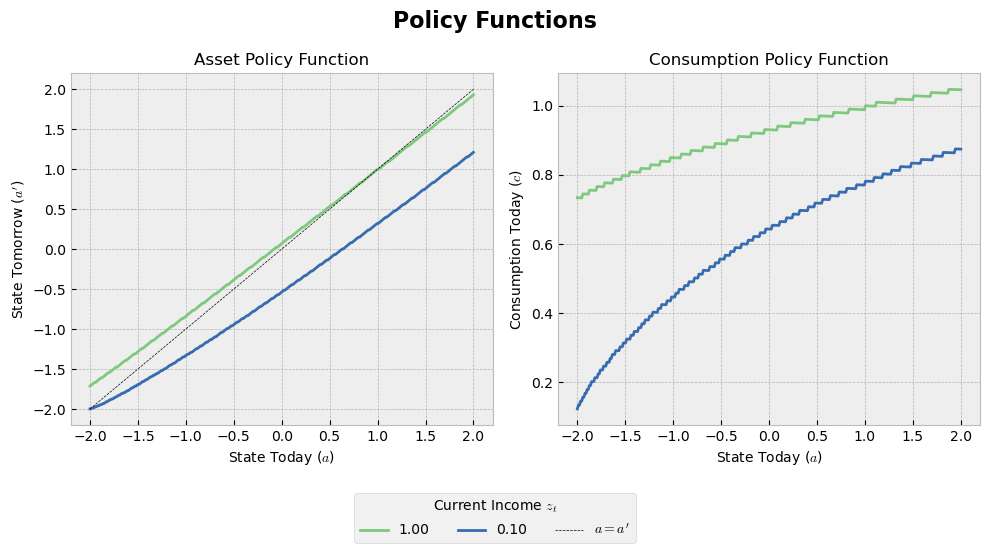

In [24]:
plot_policy_uncertainty(asset_grid, policy_a_matrix, policy_c_matrix, income_grid)

##### Asset Distributions

In [25]:
# Flattening the policy matrix (first the first row, then the row)
# This is because of the way we structured the endogenous transition matrix,
# which was first all assets in the good state, then all assets in bad state.
policy_a_flat = policy_a_matrix.flatten(order='C')

In [26]:
# Sorting following the values of policy a
sorted_indices = np.argsort(policy_a_flat)

sorted_policy_a_flat = policy_a_flat[sorted_indices]
sorted_stationary_distribution = stationary_distribution[0][sorted_indices]

In [27]:
# Calculating the CDF
cdf_stationary_distribution = np.cumsum(sorted_stationary_distribution)

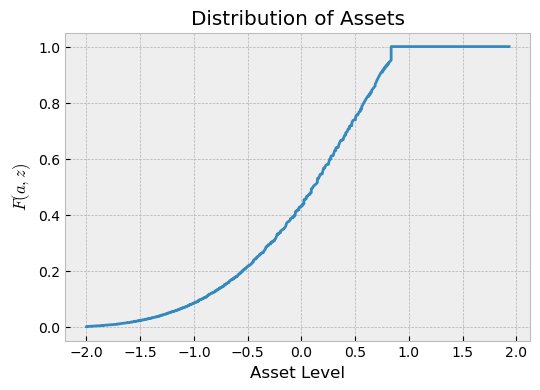

In [28]:
# Plotting
## Object
plt.figure(figsize=(6, 4))

## Plot
plt.plot(sorted_policy_a_flat, cdf_stationary_distribution)

## Labels
plt.xlabel("Asset Level")
plt.ylabel(r"$F(a, z)$")
plt.title("Distribution of Assets")

## Show
plt.grid(True)
plt.show()

The fixed point is slightly below 1. Although this is different from Tiago's, it is consistent with Huggett's Figure 2.

We now calculate the Gini coefficient and the standard deviation of asset holdings.

To do so, we will simulate and economy of 10,000 agents that has the same distribution of assets as the stationary one.

In [29]:
# Number of agents
num_agents = 10000

# Array of indexes
array_coefficients_gini_index = np.around(cdf_stationary_distribution * num_agents, 0).astype(int) - 1

# Initializing array
array_assets_agents = np.zeros(num_agents)

# Simulating the distribution
for num_agent in range(num_agents):
    # Grabbing what is the minimum 'quantile' that accomodates that agent
    min_quantile = np.min(array_coefficients_gini_index[array_coefficients_gini_index >= num_agent])
    
    # Index of asset
    min_index = np.where(array_coefficients_gini_index == min_quantile)[0][0]

    # Giving that asset level to agent
    array_assets_agents[num_agent] = sorted_policy_a_flat[min_index]

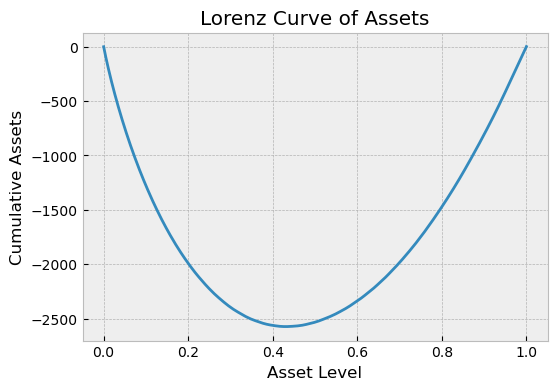

In [30]:
# Calculating Lorenz curve and plotting it
array_assets_lorenz = np.cumsum(array_assets_agents)
cumulative_share_agents = np.cumsum(np.ones(num_agents) / num_agents)

## Object
plt.figure(figsize=(6, 4))

## Plot
plt.plot(cumulative_share_agents, array_assets_lorenz)

## Labels
plt.xlabel("Asset Level")
plt.ylabel("Cumulative Assets")
plt.title("Lorenz Curve of Assets")

## Show
plt.grid(True)
plt.show()

To calculate the Gini, I took a function from [StackOverflow](https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy).

In [31]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""

    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
        
    return diffsum / (len(x)**2 * np.mean(x))

In [32]:
# Calculating Gini coefficient
print(f"Gini coefficient with sigma = {param_dict_market['sigma']}: {round(gini_coefficient(array_assets_agents), 2)}")

Gini coefficient with sigma = 1.5: -6411.1


In [33]:
# Calculating standard deviation
print(f"Standard deviation with sigma = {param_dict_market['sigma']}: {round(np.std(array_assets_agents), 2)}")

Standard deviation with sigma = 1.5: 0.63
